# BERT预训练

为什么这章有标题呢？因为代码实在太太太太长了，只能在开头吐槽一下

## BETR模型实现

In [3]:
import torch
from torch import nn 
from d2l import  torch as d2l

### 输入表示

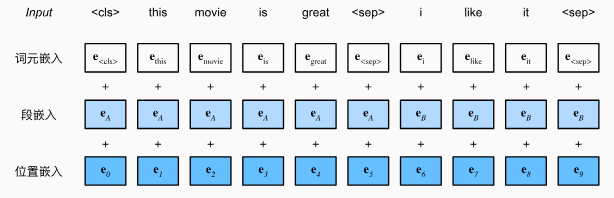

##### 为上下句添加标签（段嵌入）

In [4]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<seq>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

### 完整模型

In [5]:
class BERTEncoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens) # 词嵌入
        self.segment_embedding = nn.Embedding(2, num_hiddens) # 段嵌入
        self.blks = nn.Sequential() # 编码块
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
            
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))
    
    def forward(self, tokens, segments, valid_lens):
        # embedding
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [7]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

In [10]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

### 预训练任务

在 Encoder 后接一个mlp做任务

##### Masked Language Modeling

只取出被 [MASK] 的那些位置的特征，送入 MLP

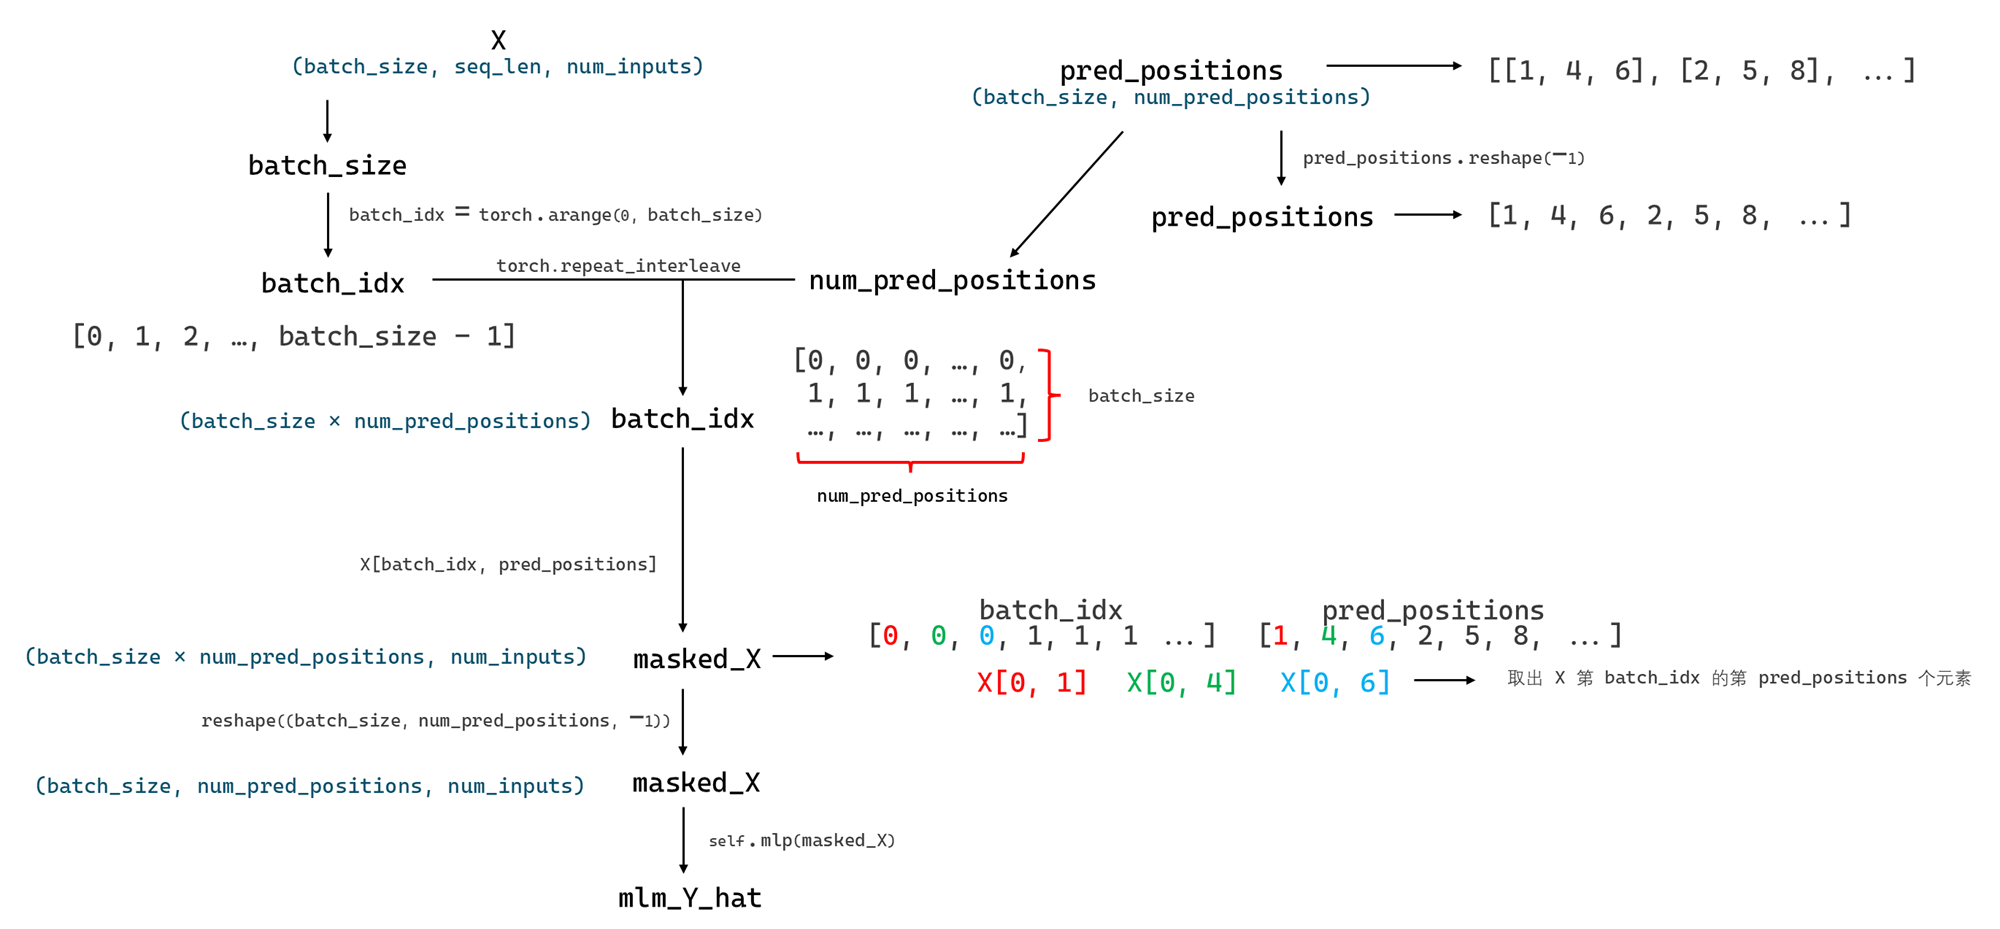

In [11]:
class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super().__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))
    
    def forward(self, X, pred_positions):
        # X: [batch_size, num_pred_positions, num_inputs]
        # pred_positions: [batch_size, num_pred_positions]
        # 将pred_positions转换为batch索引
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]

        # 生成batch索引
        batch_idx = torch.arange(0, batch_size)
        # 重复batch索引以匹配预测位置的数量
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        
        # 使用batch索引和预测位置从X中提取相应的部分
        masked_X = X[batch_idx, pred_positions]
        # 重塑masked_X以匹配MLM输入的形状
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [13]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [19]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

##### Next Sentence Prediction

预测两个句子是否是连着的

In [16]:
class NextSentencePred(nn.Module):
    def __init__(self, num_inputs, **kwargs):
        super().__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        return self.output(X)

In [20]:
encoded_X = torch.flatten(encoder_X, start_dim=1)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [22]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

### 整合代码

In [23]:
class BERTModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super().__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                                   ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                                   dropout, max_len=max_len, key_size=key_size,
                                   query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)
    
    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None

        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :])) # 每个句子的第一个字符<cls>用于分类
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## 用于预训练的数据集

In [ ]:
import pandas as pd
import random
import torch
from d2l import torch as d2l

In [ ]:
def _read_wiki(data_dir):
    df = pd.read_parquet(data_dir)
    print(df.columns)
    # 提取文本内容列并转换为列表
    lines = df['text'].tolist()
    print("reading")
    paragraphs = [line.strip().lower().split(' . ')
                for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)#在段落间进行打乱
    return paragraphs

### 预训练数据集

##### 生成下一句预测任务的数据

In [43]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        next_sentence = random.choice(random.choice(paragraphs)) # 先随机选一个段落，再随机选一句话
        is_next = False
    return sentence, next_sentence, is_next

In [44]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        
        # 加上三个特殊字符， 1 <cls>, 2<sep>
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

##### 生成遮蔽语言模型任务的数据

In [45]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None

        # 80%概率替换为<mask>，10%概率替换为原词，10%概率替换为随机词
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
        
    return mlm_input_tokens, pred_positions_and_labels

In [46]:
def _get_mlm_data_from_tokens(tokens, vocab):
    # 1. 找出可以被mask的位置（排除特殊符号<cls>和<sep>）
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 2. 计算要mask的token数量，BERT默认15%，最少1个
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    # 3. 按BERT策略对tokens进行mask，返回mask后的tokens和(mask位置, 原词)对
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    # 4. 按mask位置排序，方便后续处理
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    # 5. 拆分出所有被mask的位置和原始token
    pred_positions = [v[0] for v in pred_positions_and_labels]  # 被mask的位置
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels] # 被mask的原始token
    # 6. 返回：mask后的token序列（转为id）、mask位置、mask标签（转为id）
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

##### 将文本转换为预训练数据集

In [47]:
def _pad_bert_inputs(examples, max_len, vocab):
    # 计算每个样本最多可有多少个MLM预测位置（BERT默认15%）
    max_num_mlm_preds = round(max_len * 0.15)
    # 初始化各类输出列表
    all_token_ids, all_segments, valid_lens = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    # 遍历每个样本，分别处理
    for (token_ids, pred_positions, mlm_pred_labels_ids, segments, is_next) in examples:
        # 1. 填充token_ids到max_len长度，不足部分用<pad>补齐
        all_token_ids.append(
            torch.tensor(token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), dtype=torch.long))
        # 2. 填充segments到max_len长度，不足部分用0补齐
        all_segments.append(torch.tensor(segments + [0] * 
                                         (max_len - len(segments)), dtype=torch.long))
        # 3. 记录有效长度（未填充前的token数量）
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        # 4. 填充被mask的位置到max_num_mlm_preds长度，不足部分用0补齐
        all_pred_positions.append(torch.tensor(pred_positions + [0] * 
                                               (max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 5. MLM权重：被mask的为1，其余为0，长度同max_num_mlm_preds
        all_mlm_weights.append(torch.tensor([1.0] * len(mlm_pred_labels_ids) + [0.0] * 
                                            (max_num_mlm_preds - len(pred_positions)), dtype=torch.float32))
        # 6. MLM标签：被mask的token真实id，未mask部分补0，长度同max_num_mlm_preds
        all_mlm_labels.append(torch.tensor(mlm_pred_labels_ids + [0] * 
                                           (max_num_mlm_preds - len(mlm_pred_labels_ids)), dtype=torch.long))
        # 7. NSP标签：是否为下一句（0/1）
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, 
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [48]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        super().__init__()
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                     + (segments, is_next))
                     for tokens, segments, is_next in examples]
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
             examples, max_len, self.vocab)
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)


In [49]:
def load_data_wiki(batch_size, max_len):
    num_workers = d2l.get_dataloader_workers()
    paragraphs = _read_wiki("../data/wiki/train-00000-of-00001.parquet")
    train_set = _WikiTextDataset(paragraphs, max_len)#返回数据集
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
    shuffle=True, num_workers=0)
    print("down")

    print(train_set.vocab)
    #每次取这么多个样本
    return train_iter, train_set.vocab

In [52]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

Index(['text'], dtype='object')
reading
down
torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])
down
torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [53]:
len(vocab)

20256